# TF-IDF baseline

## Data loading

In [53]:
from datasets import load_from_disk
from src.utils.config_management import CONFIG

In [54]:
hf_dataset = load_from_disk(CONFIG['paths']['data']['dalip_hf_dataset'])

In [55]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['answer_id', 'question_id', 'answer_creation_date', 'answer_score', 'answer_normalized_score', 'answer_log_normalized_score', 'answer_body', 'answer_last_edit_date', 'answer_last_activity_date', 'answer_comment_count', 'answer_community_owned_date', 'question_creation_date', 'question_score', 'question_view_count', 'question_body', 'question_last_edit_date', 'question_last_activity_date', 'question_title', 'question_tags', 'question_answer_count', 'question_comment_count', 'question_favorite_count', 'question_closed_date', 'question_community_owned_date', 'answer_accepted'],
        num_rows: 42700
    })
    test: Dataset({
        features: ['answer_id', 'question_id', 'answer_creation_date', 'answer_score', 'answer_normalized_score', 'answer_log_normalized_score', 'answer_body', 'answer_last_edit_date', 'answer_last_activity_date', 'answer_comment_count', 'answer_community_owned_date', 'question_creation_date', 'question_score', 

## Data preprocessing

In [5]:
from src.utils.text_preprocessing import Preprocessor

In [7]:
preprocessor = Preprocessor()

In [8]:
hf_dataset = hf_dataset.map(preprocessor, batched=True)

In [9]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['answer_id', 'question_id', 'answer_creation_date', 'answer_score', 'answer_normalized_score', 'answer_log_normalized_score', 'answer_body', 'answer_last_edit_date', 'answer_last_activity_date', 'answer_comment_count', 'answer_community_owned_date', 'question_creation_date', 'question_score', 'question_view_count', 'question_body', 'question_last_edit_date', 'question_last_activity_date', 'question_title', 'question_tags', 'question_answer_count', 'question_comment_count', 'question_favorite_count', 'question_closed_date', 'question_community_owned_date', 'answer_accepted', 'question_text', 'answer_text'],
        num_rows: 42700
    })
    test: Dataset({
        features: ['answer_id', 'question_id', 'answer_creation_date', 'answer_score', 'answer_normalized_score', 'answer_log_normalized_score', 'answer_body', 'answer_last_edit_date', 'answer_last_activity_date', 'answer_comment_count', 'answer_community_owned_date', 'question_cr

## Model training

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

In [11]:
vectorizer = TfidfVectorizer(max_features=10000, stop_words=None)

In [12]:
def vectorize_qa_pairs(vectorizer, hf_dataset):
    vectorizer.fit(hf_dataset['train']['question_text'] + hf_dataset['train']['answer_text'])
    
    train_questions_vect = vectorizer.transform(hf_dataset['train']['question_text'])
    train_answers_vect = vectorizer.transform(hf_dataset['train']['answer_text'])

    
    test_questions_vect = vectorizer.transform(hf_dataset['test']['question_text'])
    test_answers_vect = vectorizer.transform(hf_dataset['test']['answer_text'])
    
    if hf_dataset['train']['question_text'][0]:
        X_train = scipy.sparse.hstack([train_questions_vect, train_answers_vect])
        X_test = scipy.sparse.hstack([test_questions_vect, test_answers_vect])
    else:
        X_train = train_answers_vect
        X_test = test_answers_vect
    
    return X_train, X_test

In [13]:
X_train, X_test = vectorize_qa_pairs(vectorizer, hf_dataset)
X_train

<42700x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 4784584 stored elements in Compressed Sparse Row format>

In [33]:
train_targets_df = pd.DataFrame(hf_dataset['train']).select_dtypes(exclude=['object'])

In [34]:
train_targets_df['answer_standardized_score'] = train_targets_df.groupby('question_id')['answer_score'].transform(
    lambda x: x - x.mean() / x.std() if x.std() > 0 else 0)

In [47]:
%%time

TARGET_COL = 'answer_log_normalized_score'

regression_model = LinearRegression()
regression_model.fit(X_train, train_targets_df[TARGET_COL])

Wall time: 27.9 s


LinearRegression()

## Evaluation

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from collections import defaultdict
from src.evaluation import RankingEvaluator

In [37]:
wandb_config = defaultdict(dict)

wandb_config['preprocessing'] = preprocessor.__dict__

wandb_config['vectorizer'] = vectorizer.get_params()

wandb_config['regression_model'] = defaultdict(dict)
wandb_config['regression_model']['regressor_type'] = str(regression_model)
wandb_config['regression_model']['n_features'] = regression_model.n_features_in_
wandb_config['regression_model']['params'][str(regression_model)] = regression_model.get_params()

wandb_config['target'] = TARGET_COL

wandb_config

defaultdict(dict,
            {'preprocessing': {'question_columns': ['question_title',
               'question_body'],
              'answer_columns': ['answer_body'],
              'preserve_html_tags': None},
             'vectorizer': {'analyzer': 'word',
              'binary': False,
              'decode_error': 'strict',
              'dtype': numpy.float64,
              'encoding': 'utf-8',
              'input': 'content',
              'lowercase': True,
              'max_df': 1.0,
              'max_features': 10000,
              'min_df': 1,
              'ngram_range': (1, 1),
              'norm': 'l2',
              'preprocessor': None,
              'smooth_idf': True,
              'stop_words': None,
              'strip_accents': None,
              'sublinear_tf': False,
              'token_pattern': '(?u)\\b\\w\\w+\\b',
              'tokenizer': None,
              'use_idf': True,
              'vocabulary': None},
             'regression_model': defaultd

In [67]:
run = wandb.init(
    project='dalip-stackoverflow-answer-ranking',
    config=wandb_config,
    tags=['tfidf', 'baseline']
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bunnynobugs to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


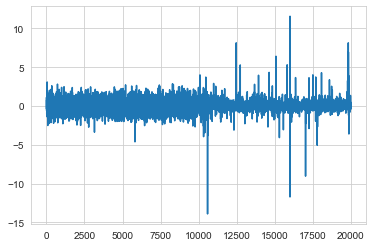

In [48]:
if isinstance(regression_model, LinearRegression):
    plt.plot(regression_model.coef_)

### Compute metrics

In [39]:
targets = hf_dataset['test']['answer_normalized_score']

In [40]:
predictions = regression_model.predict(X_test)

In [45]:
pd.Series(predictions).describe()

count    10563.000000
mean         1.896571
std         14.488272
min       -186.832871
25%         -7.198578
50%          1.472467
75%         10.555554
max         70.133316
dtype: float64

In [41]:
test_question_ids = hf_dataset['test']['question_id']

In [42]:
evaluator = RankingEvaluator(ndcg_k=list(range(1, 11)), 
                             ndcg_gain_func='exponential', ndcg_discount_func='logarithmic')

In [46]:
metrics = evaluator(targets, predictions, test_question_ids)
if TARGET_COL not in ['answer_score', 'answer_normalized_score']:
    metrics.pop('mae')
metrics

{'ndcg@1_g.exponential_d.logarithmic': 0.4112655473491954,
 'ndcg@2_g.exponential_d.logarithmic': 0.5260027985848199,
 'ndcg@3_g.exponential_d.logarithmic': 0.6149206341222822,
 'ndcg@4_g.exponential_d.logarithmic': 0.6878475191002182,
 'ndcg@5_g.exponential_d.logarithmic': 0.7169507117082768,
 'ndcg@6_g.exponential_d.logarithmic': 0.7303784194398815,
 'ndcg@7_g.exponential_d.logarithmic': 0.7354268111056361,
 'ndcg@8_g.exponential_d.logarithmic': 0.738884223959666,
 'ndcg@9_g.exponential_d.logarithmic': 0.7414698342654205,
 'ndcg@10_g.exponential_d.logarithmic': 0.7420603482302048,
 'hit_rate@1': 0.2802056555269923}

In [76]:
wandb.log(metrics)

### Log predictions

In [77]:
predictions_df = pd.DataFrame()
predictions_df['answer_id'] = hf_dataset['test']['answer_id']
predictions_df['answer_normalized_score'] = hf_dataset['test']['answer_normalized_score']
predictions_df['predicted_score'] = predictions

In [78]:
wandb.log({'predictions_table': wandb.Table(dataframe=predictions_df)})

In [79]:
run.finish()

hit_rate@1,▁
ndcg@10_g.exponential_d.logarithmic,▁
ndcg@1_g.exponential_d.logarithmic,▁
ndcg@2_g.exponential_d.logarithmic,▁
ndcg@3_g.exponential_d.logarithmic,▁
ndcg@4_g.exponential_d.logarithmic,▁
ndcg@5_g.exponential_d.logarithmic,▁
ndcg@6_g.exponential_d.logarithmic,▁
ndcg@7_g.exponential_d.logarithmic,▁
ndcg@8_g.exponential_d.logarithmic,▁
ndcg@9_g.exponential_d.logarithmic,▁
